# Age and Relationship Status Prediction With Artificial Intelligence: What Your Words Say About You

### Notebook 2: Text Data Processing and Age Groups Modeling

by Nadir Sarigul


Advertising companies more and more rely on social media platforms to advertise their products, however it is becoming increasingly hard to target specific users with the appropriate products for their age and lifestyle. For example much of the advertising is nowadays done through instagram, facebook and twitter. Yet these platforms do not have specific demographic information about their users and when they do (in the case of facebook) it is optional so not everyone provides said information. Therefore, it is hard to advertise specific products that are preferentially used by specific demongraphics to the appropriate group of people.  In the age of social media, people’s inner lives are increasingly recorded through the language they use online in the different social media platforms. One's choice of words is a direct reflection of who they are, their experiences through life and their personality. In an effort to streamline how advertising companies tailor their ads to the appropriate demographics, this project is aimed at developing an artificial intelligence model to predict people's age and relationship status from written samples. To achive this, I stuctured this project to answer three main questions:

1) Are words used by people of distinct ages and relationship status different?

2) Can we predict age based on the way people speak/write?

3) Is it possible to accuratly predict the relationship status from the assays one writes on dating profiles?


This notebook contains all the code used for cleaning, processing and modeling of the OkCupid profile dataset from the Date-A-Scientist Project (Code Academy) which contains information from 59,946 users. This dataset was scraped from active profiles in 2012 and contains several layers of information on gender, sexual orientation, ethnicity, physical features, drinking, and drug habits as well as information on income, religion, and education level. It also contains a series of open ended free style written assays where each user writes about themselves in response to specific prompts. These assays were taken and used as written samples to develop machine learning models that predict age and relationship status. 

# Data Import and Methodologies 

In [1]:
# let's get started importing the necessary libraries
import re
import string

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
np.random.seed(0)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

#next we import the data, which is a new table containing the cleaned data from the exploratory analysis done in Jupyter Notebook #1
data = pd.read_csv("data/eda_data.csv.gz")
#df = df.sample(frac=0.2)

import nltk
#nltk.download("popular")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          59934 non-null  int64 
 1   body_type    54642 non-null  object
 2   drinks       56951 non-null  object
 3   drugs        45859 non-null  object
 4   education    53310 non-null  object
 5   essay0       54448 non-null  object
 6   essay1       52368 non-null  object
 7   essay2       50300 non-null  object
 8   essay3       48463 non-null  object
 9   essay4       49403 non-null  object
 10  essay5       49089 non-null  object
 11  essay6       46170 non-null  object
 12  essay7       47489 non-null  object
 13  essay8       40715 non-null  object
 14  essay9       47337 non-null  object
 15  ethnicity    54260 non-null  object
 16  height       59931 non-null  object
 17  job          51739 non-null  object
 18  offspring    24381 non-null  object
 19  orientation  59934 non-nu

# Text Data Preparation

Our project focus on using written samples to develop a predictive model of age and marital status, thus it is vital that our algorithms can analyse text and understand the meaning of text. To do that, I will use natural language processing (NLP) which uses artificial intelligence principles to analyze, understand and ascribe meaning to text. 
Because language is messy and complex in order to be able to derive good models from text data, we have to do significant pre-processing of the data

In [3]:
## Creation of a new dataframe containing all the information needed for modeling (essays, age group and relationship status)
essay= data[['Agegroup','status','essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9']]

In [4]:
essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Agegroup  59934 non-null  object
 1   status    59934 non-null  object
 2   essay0    54448 non-null  object
 3   essay1    52368 non-null  object
 4   essay2    50300 non-null  object
 5   essay3    48463 non-null  object
 6   essay4    49403 non-null  object
 7   essay5    49089 non-null  object
 8   essay6    46170 non-null  object
 9   essay7    47489 non-null  object
 10  essay8    40715 non-null  object
 11  essay9    47337 non-null  object
dtypes: object(12)
memory usage: 5.5+ MB


In [5]:
# drop columns in the original datafram to avoid duplication of the information in the final dataframe once I merge it with the essay dataframe created above
data = data.drop(['age','Agegroup','status','essay0', 'essay1', 'essay2', 
                      'essay3', 'essay4', 'essay5', 'essay6',
                      'essay7', 'essay8', 'essay9'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body_type    54642 non-null  object
 1   drinks       56951 non-null  object
 2   drugs        45859 non-null  object
 3   education    53310 non-null  object
 4   ethnicity    54260 non-null  object
 5   height       59931 non-null  object
 6   job          51739 non-null  object
 7   offspring    24381 non-null  object
 8   orientation  59934 non-null  object
 9   religion     39714 non-null  object
 10  sex          59934 non-null  object
 11  sign         48881 non-null  object
 12  smokes       54424 non-null  object
 13  speak        59934 non-null  object
dtypes: object(14)
memory usage: 6.4+ MB


The text data had several null values because not all users wrote all the different assays. Since I did not want to loose data, and all the users in my dataset had at least written one assay, I proceeded with replacing null values with the string "missingvalue". 

In [7]:
#replace null values in dataframe assay with "missingvalue" string
essay = essay.replace(np.nan, "missingvalue")

In [8]:
# join all the different essays into a new column named "text" 
essay["text"] = essay[['essay0', 'essay1', 'essay2', 
                      'essay3', 'essay4', 'essay5', 'essay6',
                      'essay7', 'essay8', 'essay9']].apply(lambda x: " ".join(x), axis=1)

In [9]:
# drop all different essay columns from the dataframe essay to avoid duplications with the new column "text"
essay = essay.drop(['essay0', 'essay1', 'essay2', 
                      'essay3', 'essay4', 'essay5', 'essay6',
                      'essay7', 'essay8', 'essay9'], axis=1)


In [10]:
essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Agegroup  59934 non-null  object
 1   status    59934 non-null  object
 2   text      59934 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [11]:
essay.isnull().sum()

Agegroup    0
status      0
text        0
dtype: int64

# Text Data Cleaning 

In [12]:
import nltk

#nltk.download("popular")
#pip install -U textblob
#from textblob import TextBlob

from nltk.corpus import stopwords

## Stopwords

Now that my data is complete and there are no null values left, I proceeded with cleaning the text in preparation for modeling. As part of the cleaning I removed the punctuation and the string that I had previously entered for missing values. I also removed stop words, which basically are very common words that appear in every sentence. These do not add much value and introduce noise. In addition, I also removed numbers and extra letters (eg. sssaaaaasssccsf) and made the text all lower case. 

In [13]:
# Stopwords
stopwords_list = stopwords.words("english")
stopwords_list += list(string.punctuation)
stopwords_list += ["missingvalue"]

In [14]:
#remove punctuation, numbers and stopwords and extra letters

In [15]:
def clean_essay(text):
    #words = set(nltk.corpus.words.words())
    #stopwords_list = stopwords.words('english')
    #stopwords_list += ["missing", "value"]
    text = text.lower()
    text = re.sub('<[^>]*>', ' ', text)
    
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    text = " ".join(word for word in text.split() if word not in stopwords_list)
 
    # Tokenize (convert from string to list)
    text = text.split()
    
    # Stemming (remove -ing, -ly, ...)
    #ps = nltk.stem.porter.PorterStemmer()
    #text = [ps.stem(word) for word in text]
    
    # Lemmatization (convert the word into the root word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    
    
    # back to string from list
    text = " ".join(text)
    return text
    
    
    

In [16]:
clean_essay(" geese, rocks, goes")

'goose rock go'

In [17]:
def add_clean_text(data, column):
    #txt_df = data.copy()
    data[column +"_lemmatize"] = data[column].apply(lambda x: clean_essay(x))
    
    return data

In [18]:
txt_df= add_clean_text(essay, "text")

In [19]:
txt_df

,Agegroup,status,text,text_lemmatize
0,18-35,single,about me:<br />\n<br />\ni would love to think...,would love think kind intellectual either dumb...
1,18-35,single,i am a chef: this is what that means.<br />\n1...,chef mean workaholic love cook regardless whet...
2,35+,single,"i'm not ashamed of much, but writing public te...",ashamed much writing public text online dating...
3,18-35,single,i work in a library and go to school. . . read...,work library go school reading thing written o...
4,18-35,single,hey how's it going? currently vague on the pro...,hey going currently vague profile know come so...
...,...,...,...,...
59929,35+,single,"vibrant, expressive, caring optimist. i love b...",vibrant expressive caring optimist love people...
59930,18-35,single,i'm nick.<br />\ni never know what to write ab...,nick never know write sure hand southern calif...
59931,35+,single,"hello! i enjoy traveling, watching movies, and...",hello enjoy traveling watching movie hanging f...
59932,18-35,single,"""all i have in this world are my balls and my ...",world ball integrity one take either away momm...


In [20]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub('<[^>]*>', ' ', text)
   
    
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    

    text = " ".join(word for word in text.split() if word not in stopwords_list)
    
    return text

In [21]:
txt_df['clean'] = txt_df['text'].apply(clean_text)
txt_df["clean"]

0        would love think kind intellectual either dumb...
1        chef means workaholic love cook regardless whe...
2        ashamed much writing public text online dating...
3        work library go school reading things written ...
4        hey going currently vague profile know come so...
                               ...                        
59929    vibrant expressive caring optimist love people...
59930    nick never know write sure hands southern cali...
59931    hello enjoy traveling watching movies hanging ...
59932    world balls integrity one take either away mom...
59933    odd little enemy status someone makes seem int...
Name: clean, Length: 59934, dtype: object

## Nonsense Words

Because the text data contains many nonsense words (words that follows English phonics patterns but does not have its own meaning) that may add additional noise when modeling, I created a new colum where the nonsense words were removed using the following methodology

In [22]:
import nltk
words = set(nltk.corpus.words.words())

sent = "amgg ass Io andiamo to the beach with my aboutme amico nnndnd hhhh ahhhhh wooooo aaa ahhh."
text = " ".join(w for w in nltk.wordpunct_tokenize(sent) \
         if w.lower() in words or not w.isalpha())
text

'ass Io to the beach with my .'

In [23]:
f = lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words)
#txt_df["text_lemmatize"] = txt_df["text_lemmatize"].apply(f)

In [24]:
txt_df["nonsense_text"] = txt_df["clean"].apply(f)

Now let's see how the leght of an essay compares between the clean original text, versus text where nonsense words were removed, versus text that was lemmatized

In [25]:
len(txt_df['clean'][0])

1631

In [26]:
len(txt_df['nonsense_text'][0])

1254

In [27]:
len(txt_df['text_lemmatize'][0])

1605

# Word Clouds

I used word clouds to visualize the most frequent words used by people in the age groups

In [28]:
#pip install wordcloud

In [29]:
from wordcloud import WordCloud
def plot_wordcloud(corpus, max_words=150, max_font_size=35, figsize=(10,10), stopwords = None):
    corpus = " ".join(corpus)
    wc = WordCloud(stopwords=stopwords, collocations=True,background_color='black', max_words=max_words, max_font_size=max_font_size)
    
    wc = wc.generate(corpus) 
    
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show()

## Age

# 18-35:


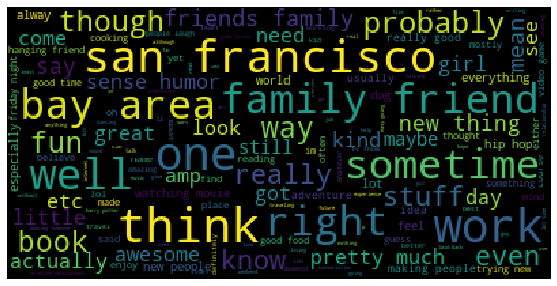

# 35+:


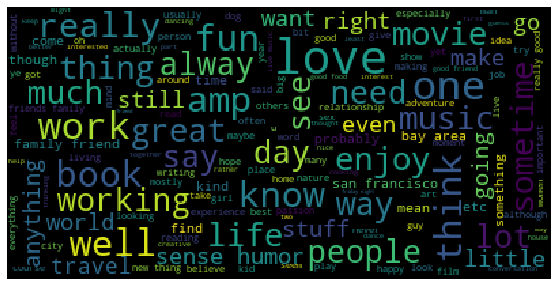

In [30]:
for i in txt_df["Agegroup"].unique():
    print("# {}:".format(i))
    plot_wordcloud(corpus=txt_df[txt_df["Agegroup"]==i]["clean"], max_words=150, max_font_size=35, figsize=(10,5))

Looking at these word clouds there is a bit of a distinction in the most used words among the different age groups.  

# Frequent Words

In [31]:
from nltk import FreqDist
def frequent(text, number = 30, figsize=(10,7)):
    tokens = nltk.tokenize.word_tokenize(','.join(text))
    freq = FreqDist(tokens)
    #display(freq.most_common(number))
    most_common = pd.DataFrame(freq.most_common(number),
                           columns=['word','count']).sort_values('count',
                                                                 ascending=True)
    #plot
    fig, ax = plt.subplots(figsize=figsize)
    most_common.set_index('word').plot(kind='barh',ax=ax)
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()

## Age

********** 18-35: *************


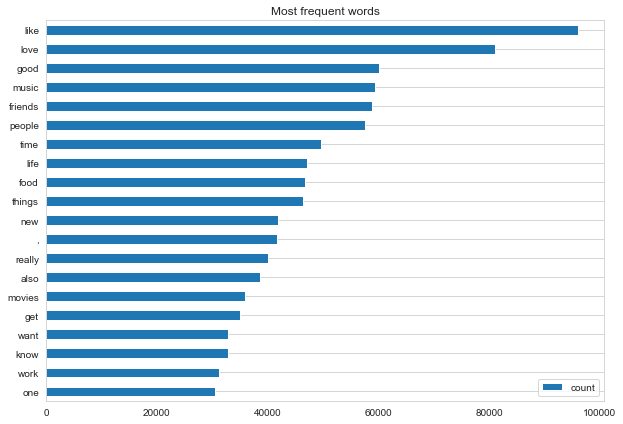

********** 35+: *************


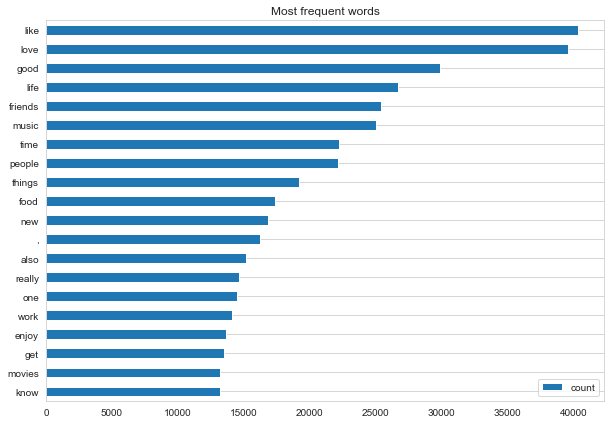

In [32]:
for i in txt_df["Agegroup"].unique():
    print("********** {}: *************".format(i))
    frequent(txt_df[txt_df["Agegroup"]==i]["clean"],  20)

# Modeling

Now that the data is all clean and we have explored it, its time to start modeling. I will start by importing the tools and dataframe (from above) that I will need to build and test the models.

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
# preprocesing 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, roc_curve


#from imblearn.over_sampling import RandomOverSampler
#import imblearn.pipeline

import joblib

import warnings
warnings.filterwarnings('ignore')

In [34]:
#data for modeling
test_data = txt_df.copy()

In [35]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Agegroup        59934 non-null  object
 1   status          59934 non-null  object
 2   text            59934 non-null  object
 3   text_lemmatize  59934 non-null  object
 4   clean           59934 non-null  object
 5   nonsense_text   59934 non-null  object
dtypes: object(6)
memory usage: 2.7+ MB


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   body_type    54642 non-null  object
 1   drinks       56951 non-null  object
 2   drugs        45859 non-null  object
 3   education    53310 non-null  object
 4   ethnicity    54260 non-null  object
 5   height       59931 non-null  object
 6   job          51739 non-null  object
 7   offspring    24381 non-null  object
 8   orientation  59934 non-null  object
 9   religion     39714 non-null  object
 10  sex          59934 non-null  object
 11  sign         48881 non-null  object
 12  smokes       54424 non-null  object
 13  speak        59934 non-null  object
dtypes: object(14)
memory usage: 6.4+ MB


In [37]:
#data for app and marital status
df = pd.concat([data, test_data], axis = 1)
df.to_csv("data/clean_data.csv.gz", index=False, compression="gzip")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   body_type       54642 non-null  object
 1   drinks          56951 non-null  object
 2   drugs           45859 non-null  object
 3   education       53310 non-null  object
 4   ethnicity       54260 non-null  object
 5   height          59931 non-null  object
 6   job             51739 non-null  object
 7   offspring       24381 non-null  object
 8   orientation     59934 non-null  object
 9   religion        39714 non-null  object
 10  sex             59934 non-null  object
 11  sign            48881 non-null  object
 12  smokes          54424 non-null  object
 13  speak           59934 non-null  object
 14  Agegroup        59934 non-null  object
 15  status          59934 non-null  object
 16  text            59934 non-null  object
 17  text_lemmatize  59934 non-null  object
 18  clean 

Machine learning models such as the ones that I am about to implement, can only take in numeric inputs. However, so far the data we want to use for modeling is words. The NLP toolbox has methods that can be used to process the text into numeric inputs that can be used by machine learning models. Here, I will use two different methods to convert text into numerical inputs to build different models. I will use Count Vectorization and Term Frequency-Inverse Document Frequency (Tfidf Vectorizer).The count vectorizater method counts the number of occurrences each words appears in a given written sample. On the other hand the Tfidf vectorizer calculates word frequency scores which not only takes into consideration the number of occurrences for each words in a given written sample but also how frequently it occurs in all written samples in the dataset. That helps highlighting the words that are more interesting (eg. frequent in a certain written sample but not across all written samples). 

In addition, my dataset does not provide a separate training and test dataset, so I splited the original dataset such that 70% of the data will be used for training and 30% of the data will be used for testing.

For the majority of the models I have decided to use the text samples that I had cleaned without lemmatizing or nonsense words removal and have explored the text data produced using those additional cleaning steps only with the best model generated with the orginal cleaned data.

# Age Models

First, I will build a function to return the evaluation metrics for each model, so that later I can easily call it without having to code it again. 

In [38]:
#pip install yellowbrick

In [39]:
from yellowbrick.classifier import ROCAUC

In [40]:
def model_cl(model,X_train, X_test):   
    print("***********************************************")
    print(f"training score:  {round(model.score(X_train, y_train), 2)}\
        Test score:  {round(model.score(X_test, y_test),2)}")
    print("\n")
    print("********************Cl REPORT****************")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print(metrics.classification_report(y_test, y_pred))

    print("\n")
    print("***********************************************")

    fig, ax = plt.subplots(ncols=2,figsize=(12,5))
    plot_confusion_matrix(model,X_test, y_test, cmap='Blues',xticks_rotation='vertical',normalize='true',
                                display_labels=["18-35", "35+"],
                                ax= ax[0])


    curve  = ROCAUC(model,encoder={0:"18-35", 
                                   1:"35+"})#https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html

    curve .fit(X_train, y_train)        # Fit the training data to the visualizer
    curve .score(X_test, y_test)        # Evaluate the model on the test data
    curve .show()                       # Finalize and show the figure 
    #plt.show()

Now let's see how many users and their written samples do we have in each age group

In [41]:
test_data["Agegroup"].value_counts(dropna= False)

18-35    43071
35+      16863
Name: Agegroup, dtype: int64

In [42]:
age_dict = {"18-35":0, "35+":1}
test_data["Agegroup"] = test_data["Agegroup"].map(age_dict)
test_data["Agegroup"].value_counts()

0    43071
1    16863
Name: Agegroup, dtype: int64

It looks like there is a significant imbalance in the number of users in the different age groups, which then will bias the model. I will deal with this issue below.

## Tfidf Vectorizer

In [43]:
y = test_data["Agegroup"]
X = test_data["clean"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


vectorizer =  TfidfVectorizer(stop_words = stopwords_list, encoding='utf-8',decode_error='ignore', max_features = 30000)
X_train_tf = vectorizer.fit_transform(X_train) 
X_test_tf = vectorizer.transform(X_test)

### Dummy Classifier

Because developing machine learning models rely on multiple attempts to increase the success rate of classification tasks, evaluating the baseline success rate is an important step to take. We can do this using the Dummy Classifier, which sets the baseline performance (i.e. the success rate that one should expect to achive by simply guessing).

***********************************************
training score:  0.72        Test score:  0.72


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.72      1.00      0.83     12877
           1       0.00      0.00      0.00      5104

    accuracy                           0.72     17981
   macro avg       0.36      0.50      0.42     17981
weighted avg       0.51      0.72      0.60     17981



***********************************************


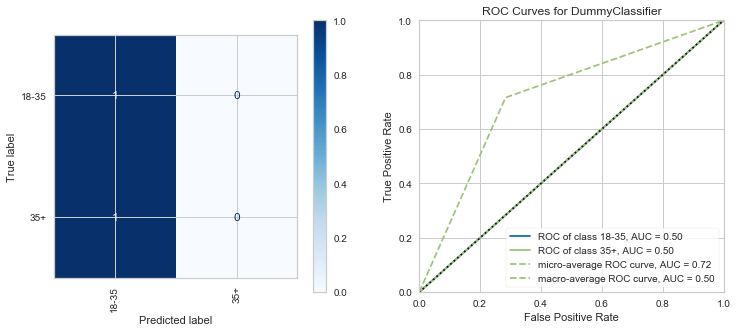

In [44]:
dm= DummyClassifier()
dm.fit(X_train_tf, y_train)
model_cl(dm, X_train_tf, X_test_tf)

Looks like using Tfidf vectorizer to input the data onto the models, the Dummy Classifier recalls either the younger or older age group 100% of the times as younger  (indicating that it does not recognize the older group at all) and has 72% accuracy. Now that we established the baseline, let's see if we can generate a model that is accurate predicting the age groups.

As we seen above the number os users in each class is very imbalanced, with the majority of the users in the 18-35 class, which maybe one of the reasons why the Dummy Classifier has such a strong bias when predicting. To balance the data, I use the class weight method to balance the classes. What this method does is during the model training, it give more weight to the minority and a higher penalty to the majority class thus allowing for more balance in learning the features of the different classes and reducing the errors for the minority class.


In [45]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

weights_dict = dict(zip(np.unique(y_train), class_weights))
weights_dict

sample_weights = class_weight.compute_sample_weight(weights_dict, y_train)

We are now ready to try some models and see how well can we predict the different age groups based on the words they use

### Logistic Regression


***********************************************
training score:  0.88        Test score:  0.82


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     12877
           1       0.66      0.76      0.71      5104

    accuracy                           0.82     17981
   macro avg       0.78      0.80      0.79     17981
weighted avg       0.83      0.82      0.83     17981



***********************************************


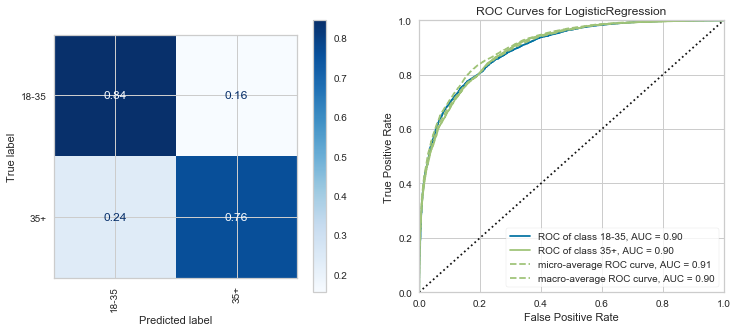

In [46]:
lr= LogisticRegression()
lr.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(lr, X_train_tf, X_test_tf)

The Logistic regression model greatly improved over the Dummy Classifier, as it has a 82% accuracy with the ability to recall correctly 84% of the younger age group and 76% of the older age. Looking at the ROC curves it looks like the model performs nicely. Moreover, the training and test scores are also relatively close indicating that the fit of the model is good. So overall this model is a good model to predict the different age groups based on their written samples

To see if I could improve the results of this model, I performed did some hyperparameter tunning.

***********************************************
training score:  0.99        Test score:  0.79


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     12877
           1       0.64      0.61      0.63      5104

    accuracy                           0.79     17981
   macro avg       0.75      0.74      0.74     17981
weighted avg       0.79      0.79      0.79     17981



***********************************************


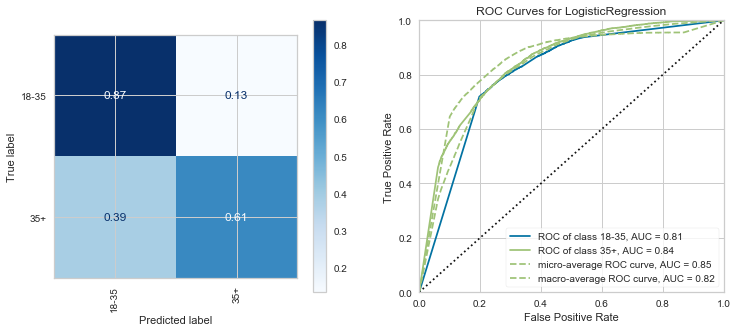

In [47]:
from sklearn.linear_model import LogisticRegression

params = dict(fit_intercept=False,C=1e12)
#logreg_param_grid = {"C":np.logspace(-3,3,7),"penalty": ["l1","l2"]}

regr = LogisticRegression(**params)
regr.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(regr, X_train_tf, X_test_tf)

It looks like altering these hyperparameters did not improve this logistic regression model

In [48]:
#code to save the model
pipe_nb_status = Pipeline(steps = [("cv" , TfidfVectorizer(stop_words = stopwords_list, 
                                                           encoding='utf-8',
                                                           decode_error='ignore',
                                                           max_features = 30000)), 
                                   ("lr", LogisticRegression())])
pipe_nb_status.fit(X_train, y_train, 
            **{'lr__sample_weight':sample_weights})

#save model
#joblib.dump(pipe_nb_status, "lr_age_model")

Pipeline(steps=[('cv',
                 TfidfVectorizer(decode_error='ignore', max_features=30000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lr', LogisticRegression())])

### Random Forest

***********************************************
training score:  0.98        Test score:  0.77


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.78      0.94      0.85     12877
           1       0.68      0.33      0.45      5104

    accuracy                           0.77     17981
   macro avg       0.73      0.63      0.65     17981
weighted avg       0.75      0.77      0.74     17981



***********************************************


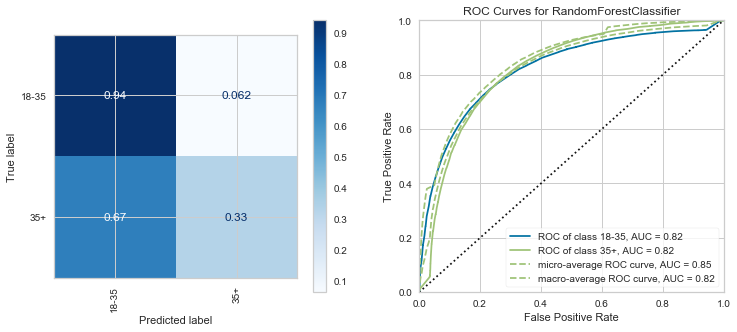

In [49]:
rf1= RandomForestClassifier(class_weight ="balanced")
rf1.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(rf1, X_train_tf, X_test_tf)

The Random Forest Classifier performs worse than the Logistic Regression model in this instance. We can see that the accurary is decreased to 77% and the model has a hard time to recall correctly the older age group with 67% of false positives. Moreover, looking at the training and tests scores it looks like the this model is overfitted as the training score is much higher than the test score is. 

Random Forest allows us to see what words were given the most importance in the choices the model made. So even though this model is not great lets take a look at what words were deemed important by the model when making its choice.

In [50]:
def plot_importance(tree, X_train, top_n=20,figsize=(10,10)):
    
    df_importance = pd.Series(tree.feature_importances_,
                      index=vectorizer.get_feature_names()
                             )
    df_importance.sort_values(ascending=True).tail(top_n).plot(
        kind='barh',figsize=figsize,title='Feature Importances')
    #return df_importance

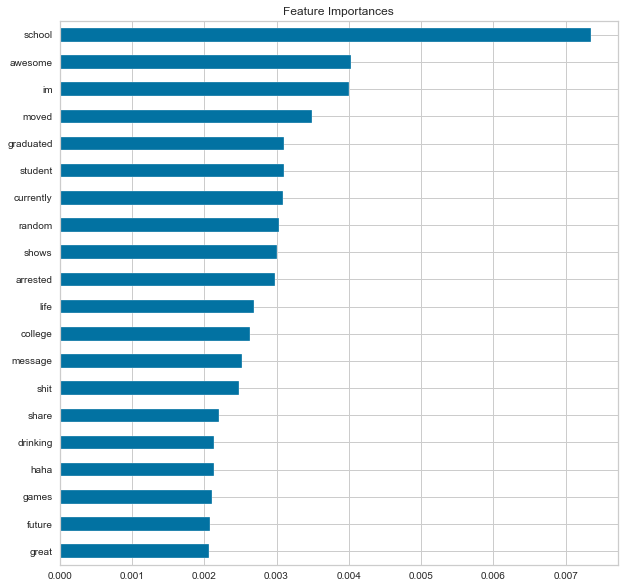

In [51]:
plot_importance(rf1, X_train_tf)

Considering that this model has bias towards the younger group it makes sense that the words of most importance are words related with younger lifestyles (such as school, student, graduated, college) rather than words related to older lifestyles. 

Because I want to test multiple different parameters, inputs and vectorizers I decided to create a function that I can recall and easily alter the different paraments in an effort to streamline my code.

As I did with the Logistic Regression model, I also decided to use that and performe some hyperparameter tunning using the Grid Search method to see if the predictive ability of the Random forest Classifier would improve

***********************************************
training score:  0.79        Test score:  0.74


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     12877
           1       0.62      0.63      0.62      5104

    accuracy                           0.78     17981
   macro avg       0.73      0.74      0.74     17981
weighted avg       0.78      0.78      0.78     17981



***********************************************


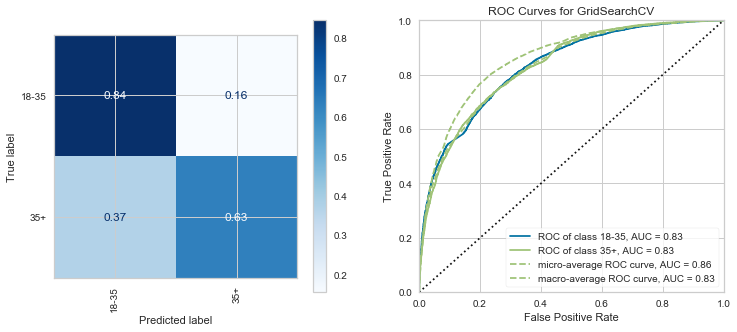

In [52]:
rf= RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [10,  100, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,  6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]   
}

grid_dt = GridSearchCV(rf, rf_param_grid,scoring='recall_macro', cv=3, n_jobs=-1)
grid_dt.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(grid_dt, X_train_tf, X_test_tf)

Tunning the hyperparameters with GridSearch resulted in a Random Forest-based model with a better overall performance, leading to an increase in accuracy and a higher ability to recall the 35+ group correctly. 

In [53]:
#create modeling function
def model(X, model, vector):
    y = test_data["Agegroup"]
    X = test_data[X]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


    vectorizer =  vector(stop_words = stopwords_list, encoding='utf-8', max_features = 30000)
    X_train_tf = vectorizer.fit_transform(X_train) 
    X_test_tf = vectorizer.transform(X_test)
    
    
    mb = model()
    mb.fit(X_train_tf, y_train, sample_weight=sample_weights)
    model_cl(mb, X_train_tf, X_test_tf)
    

### Multinomial Naive Bayes

***********************************************
training score:  0.81        Test score:  0.78


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.91      0.77      0.83     12877
           1       0.58      0.80      0.67      5104

    accuracy                           0.78     17981
   macro avg       0.74      0.79      0.75     17981
weighted avg       0.81      0.78      0.79     17981



***********************************************


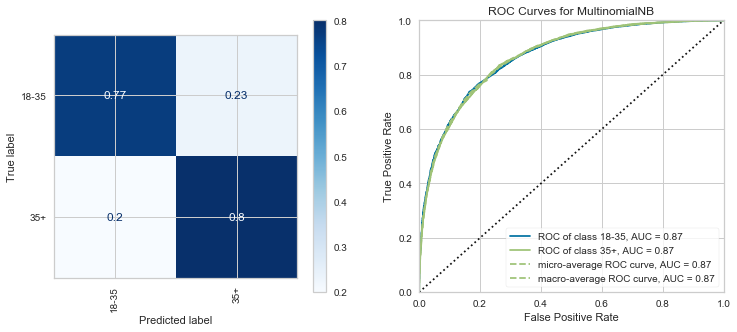

In [54]:
model("clean", MultinomialNB,TfidfVectorizer)

By comparasion with the Random Forest Classifier, the Multinomial Naive Bayes model performs much better even though its accuracy is comparable. That is easily seen by the ROC/AUC curvers and its increased ability to recall correctly the older age group. 

I further used the GridSearch method to optimize the Naive Bayes model as well in the hopes of generating a model with better predictive capacity.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
***********************************************
training score:  0.83        Test score:  0.79


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.90      0.78      0.84     12877
           1       0.58      0.79      0.67      5104

    accuracy                           0.78     17981
   macro avg       0.74      0.79      0.75     17981
weighted avg       0.81      0.78      0.79     17981



***********************************************


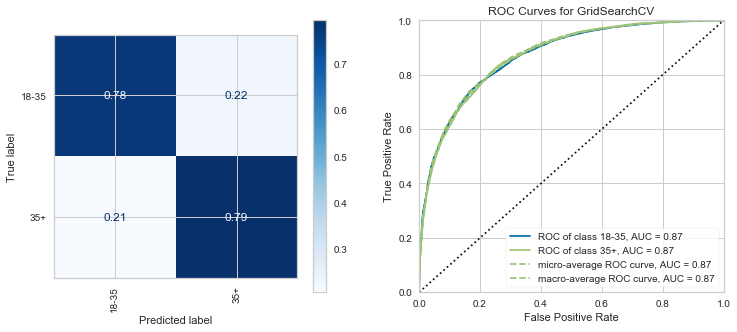

In [55]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ]}

nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5, scoring= "recall_macro")


nb_grid.fit(X_train_tf, y_train, sample_weight=sample_weights)
model_cl(nb_grid, X_train_tf, X_test_tf)

looks like using the GridSearch to tune the hyperparameters did not really improve the model generated by the multinomial naive bayes classifier.

Looking at the three different types of models that I have built, the Logistic Regression is the one that provides the best model for this dataset. Considering that additional cleaning steps may decrease noise in the data, I decided to run the Logistic Regression model with botht the text produced after lematization and the text produced after removal of nonsense words.

### Logistic Regression with Lemmatized Text

***********************************************
training score:  0.87        Test score:  0.82


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     12877
           1       0.66      0.75      0.70      5104

    accuracy                           0.82     17981
   macro avg       0.78      0.80      0.78     17981
weighted avg       0.83      0.82      0.82     17981



***********************************************


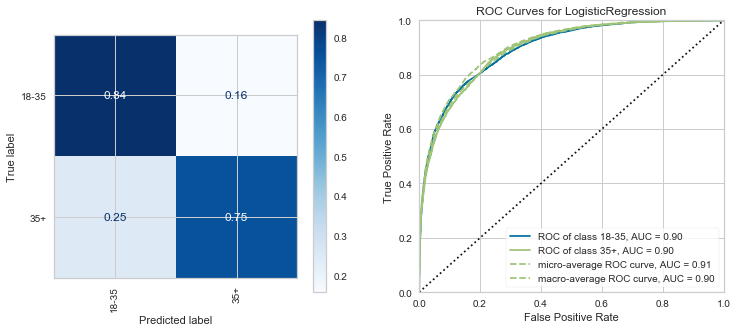

In [56]:
model("text_lemmatize", LogisticRegression,TfidfVectorizer)

### Logistic Regression without Nonsense Word

***********************************************
training score:  0.85        Test score:  0.8


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     12877
           1       0.63      0.74      0.68      5104

    accuracy                           0.80     17981
   macro avg       0.76      0.78      0.77     17981
weighted avg       0.82      0.80      0.81     17981



***********************************************


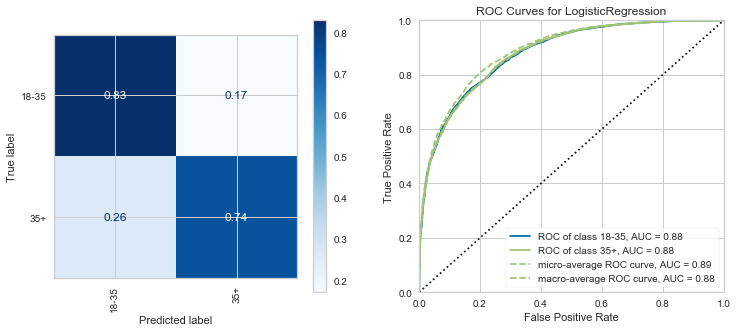

In [57]:
model("nonsense_text", LogisticRegression,TfidfVectorizer)

Looking at both models and comparing it with the original logistic regression model it looks like the additional cleaning steps that I had taken do not improve the models. In fact, removing nonsense words actually made the model a bit worse at being able to accuratly predict the older age group (from 80% to 73%). Lematizing the words did not result in a big change retaining the same accuracy as the original logistic regression model, but it resulted in a slight loss in ability to predict both the younger and the older group (1% in both groups).

### N-gram

Because combination of words sometimes are more meaningful, I decided to use the ngram_range method to have model model take in combinations of 2 words (bigrams) rather than a single word (unigrams).

In [58]:
def model(X, model, vector):
    y = test_data["Agegroup"]
    X = test_data[X]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)


    vectorizer =  vector(stop_words = stopwords_list, encoding='utf-8', max_features = 30000, ngram_range=(2, 2))
    X_train_tf = vectorizer.fit_transform(X_train) 
    X_test_tf = vectorizer.transform(X_test)
    
    
    mb = model()
    mb.fit(X_train_tf, y_train, sample_weight=sample_weights)
    model_cl(mb, X_train_tf, X_test_tf)

#### Multinomial Naive Bayes

***********************************************
training score:  0.83        Test score:  0.77


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.90      0.76      0.83     12877
           1       0.57      0.79      0.66      5104

    accuracy                           0.77     17981
   macro avg       0.74      0.78      0.74     17981
weighted avg       0.81      0.77      0.78     17981



***********************************************


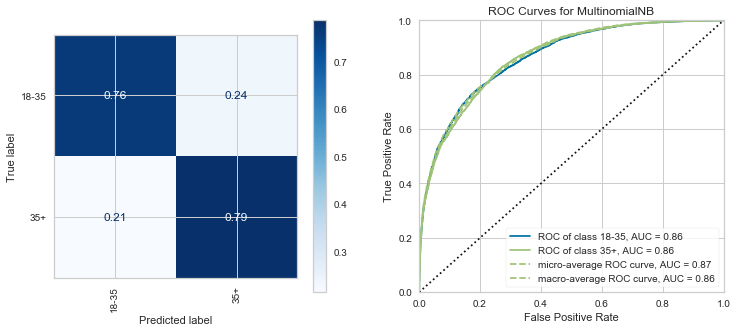

In [59]:
model("clean", MultinomialNB,TfidfVectorizer)

#### Logistic Regression

***********************************************
training score:  0.89        Test score:  0.8


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     12877
           1       0.62      0.71      0.66      5104

    accuracy                           0.80     17981
   macro avg       0.75      0.77      0.76     17981
weighted avg       0.81      0.80      0.80     17981



***********************************************


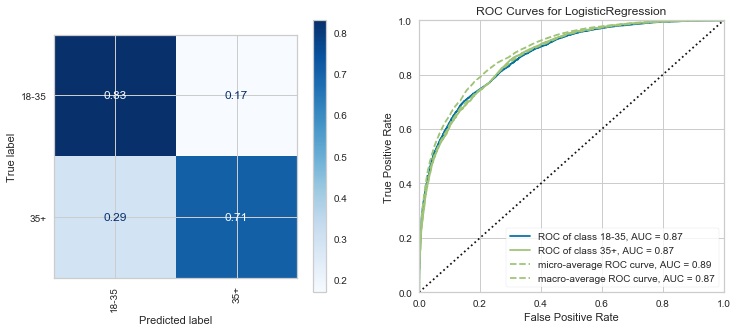

In [60]:
model("clean", LogisticRegression,TfidfVectorizer)

Using bigrams did not help either the naive bayes nor the logistic regression models to become better. In fact, both models perform more poorly when taking bigrams rather than unigrams. Thus, the logistic regression with the original clean data remains the best model that I have built so far to predict age groups based on written samples.

## Count Vectorizer 

To see if the models could be improved, I decided to run the same models as above but this time using a different vectorizer method.

### Dummy Classifier

***********************************************
training score:  0.28        Test score:  0.28


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12877
           1       0.28      1.00      0.44      5104

    accuracy                           0.28     17981
   macro avg       0.14      0.50      0.22     17981
weighted avg       0.08      0.28      0.13     17981



***********************************************


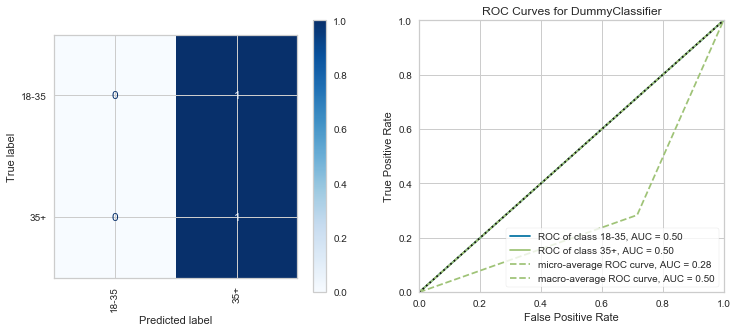

In [61]:
model("clean", DummyClassifier, CountVectorizer)

### Random Forest Classifier

***********************************************
training score:  0.97        Test score:  0.76


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12877
           1       0.60      0.44      0.51      5104

    accuracy                           0.76     17981
   macro avg       0.70      0.66      0.67     17981
weighted avg       0.74      0.76      0.75     17981



***********************************************


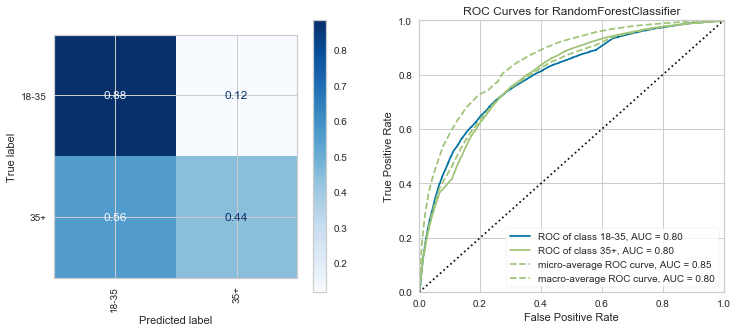

In [62]:
model("clean", RandomForestClassifier, CountVectorizer)


### Multinomial Naive Bayes

***********************************************
training score:  0.82        Test score:  0.77


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     12877
           1       0.57      0.78      0.66      5104

    accuracy                           0.77     17981
   macro avg       0.74      0.78      0.74     17981
weighted avg       0.81      0.77      0.78     17981



***********************************************


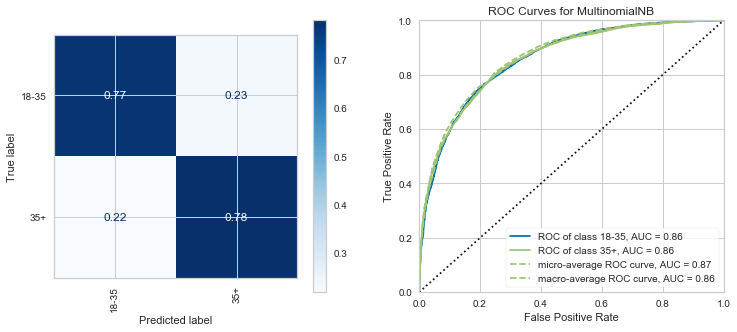

In [63]:
model("clean", MultinomialNB,CountVectorizer)

### Logistic Regression

***********************************************
training score:  0.98        Test score:  0.78


********************Cl REPORT****************
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12877
           1       0.62      0.62      0.62      5104

    accuracy                           0.78     17981
   macro avg       0.73      0.74      0.73     17981
weighted avg       0.78      0.78      0.78     17981



***********************************************


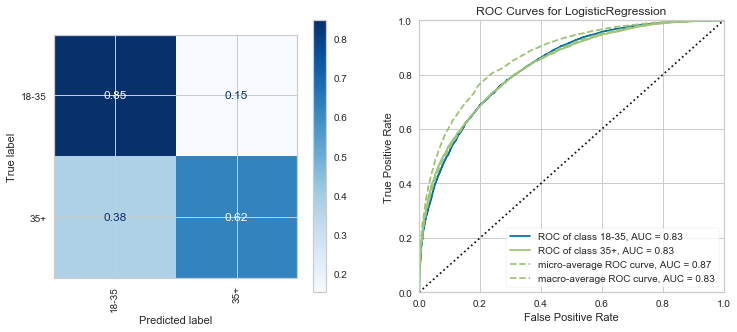

In [64]:
model("clean", LogisticRegression,CountVectorizer)

Using Count Vectorizer instead of Tfidf Vectorizer did not improve any of the models. 

# Model Evaluation

My final model to predict age groups from OKCupid data is a Logistic Regression Classifier using the clean version of the original data which is not lemmatized and still contains nonsense words. This model can accuratly predict 82% of the younger (18-35 years old) group, 80% of the older (35+) group and is overall 81% accurate.  This model seems to perform well as it is accurate and not super overfitted as seen by the fact that the training and test score are relatively close to each other (0.86 Testing Score and 0.81 Test Score). 


# Conclusions and Business Recommendations

From this project, with regards to age groups, I was able to answer the two questions that I put forward when I started the project:

#### 1) Are words used by people of distinct ages different?

This analysis clearly shows that people of different age groups do have certain preferences for words and topics that are easy to recognize with artificial intelligence. 

#### 2) Can we predict age based on the way people speak/write?

This project also shows that we can accuratly predict age groups based on written samples.


I started this project with the goal of developing a machine learning model that could be of use for advertisement agencies to screen their targets using written samples from social media (instagram comments, tweets etc).  This model can be integrated within each advertising company's traditional platforms and implemented in an automatic way such that each individual is categorized onto a specific age group.


Go to <a href = "https://github.com/dendar/Final_cap/blob/master/Marital_Status_model.ipynb"> Notebook `Marital_Status_model.ipynb` </a> for the text data analysis and modeling regarding relationship status.